<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Load-Data-and-Prepare-for-Training" data-toc-modified-id="Load-Data-and-Prepare-for-Training-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data and Prepare for Training</a></span></li><li><span><a href="#Define-Model-Architecture" data-toc-modified-id="Define-Model-Architecture-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define Model Architecture</a></span><ul class="toc-item"><li><span><a href="#Encoder" data-toc-modified-id="Encoder-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Encoder</a></span></li><li><span><a href="#Define-Helper-Functions" data-toc-modified-id="Define-Helper-Functions-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Define Helper Functions</a></span></li><li><span><a href="#Build-Encoder" data-toc-modified-id="Build-Encoder-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Build Encoder</a></span></li></ul></li><li><span><a href="#Train-Encoder" data-toc-modified-id="Train-Encoder-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train Encoder</a></span></li><li><span><a href="#Combine-Encoder-and-cGAN" data-toc-modified-id="Combine-Encoder-and-cGAN-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Combine Encoder and cGAN</a></span></li></ul></div>

# Setup

In [ ]:
import csv
import datetime
import io
import os
import time
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import Input, Model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model, save_model
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.utils import load_img, img_to_array
from numpy import asarray, ones, zeros,  load, savez_compressed
from numpy.random import randn, randint
from scipy.io import loadmat
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (BatchNormalization, Concatenate, Conv2D, Conv2DTranspose, Dense, Dropout, Embedding, Flatten, LeakyReLU, Reshape)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! nvidia-smi

Fri Mar 10 08:02:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load Data and Prepare for Training

In [ ]:
base_path = "/content/drive/MyDrive/inmates/"

images_train = load(base_path + 'data_arrays/train_images.npz')['arr_0']
bmi_train = load(base_path + 'data_arrays/bmi_train.npz', allow_pickle=True)['arr_0']

images_test = load(base_path + 'data_arrays/test_images.npz')['arr_0']
bmi_test = load(base_path + 'data_arrays/bmi_test.npz',allow_pickle=True)['arr_0']


print('Loaded: ', images_train.shape)
print('Loaded: ', bmi_train.shape)
print('Loaded: ', images_test.shape)
print('Loaded: ', bmi_test.shape)

Loaded:  (47999, 64, 64, 3)
Loaded:  (47999,)
Loaded:  (12000, 64, 64, 3)
Loaded:  (12000,)


In [ ]:
# round to nearest integer
bmi_train = np.round(bmi_train)

# convert to integers
bmi_train = bmi_train.astype(int)

bmi_train[0]

35

In [ ]:
# round to nearest integer
bmi_test = np.round(bmi_test)

# convert to integers
bmi_test = bmi_test.astype(int)

bmi_test[0]

22

# Define Model Architecture

## Encoder

In [ ]:
# define dimensions

img_rows, img_cols, img_chns = 64, 64, 3
latent_dim = 100
original_dim = 64*64*3

In [ ]:
def build_encoder():
    
    input_layer = Input(shape=(64, 64, 3))
    
    # 1st Convolutional Block
    enc = Conv2D(filters=32, kernel_size=5, strides=2, padding='same')(input_layer)
    enc = LeakyReLU(alpha=0.2)(enc)
    
    # 2nd Convolutional Block
    enc = Conv2D(filters=64, kernel_size=4, strides=2, padding='same')(enc)
    enc = BatchNormalization()(enc)
    enc = LeakyReLU(alpha=0.2)(enc)
    
    # 3rd Convolutional Block
    enc = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(enc)
    enc = BatchNormalization()(enc)
    enc = LeakyReLU(alpha=0.2)(enc)
    
    # 4th Convolutional Block
    enc = Conv2D(filters=256, kernel_size=2, strides=2, padding='same')(enc)
    enc = BatchNormalization()(enc)
    enc = LeakyReLU(alpha=0.2)(enc)
    
    # Flatten layer
    enc = Flatten()(enc)
    
    # 1st Fully Connected Layer
    enc = Dense(2048)(enc)
    enc = BatchNormalization()(enc)
    enc = LeakyReLU(alpha=0.2)(enc)
    
    # Second Fully Connected Layer
    enc = Dense(100)(enc)
    
    # Create a model
    model = Model(inputs=[input_layer], outputs=[enc])
    return model

## Define Helper Functions

In [ ]:
def euclidean_distance_loss(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [ ]:
def SSIM(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 255.00))

In [ ]:
def create_image_grid(images1, images2, labels, similarity):
    fig, axs = plt.subplots(10, 2, figsize=(10, 24))
    
    for i in range(10):
        axs[i, 0].imshow(images1[i])
        axs[i, 0].axis('off')
        axs[i, 0].set_title(f"Original: BMI {labels[i]}")
        
        axs[i, 1].imshow(images2[i])
        axs[i, 1].axis('off')
        axs[i, 1].set_title(f"Generated: SSIM {similarity[i]}")
    
    plt.tight_layout()
    return fig

In [ ]:
def plot_to_image(figure):
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

## Build Encoder

In [ ]:
# Build Encoder
encoder = build_encoder()
encoder.compile(loss=euclidean_distance_loss, optimizer='adam')

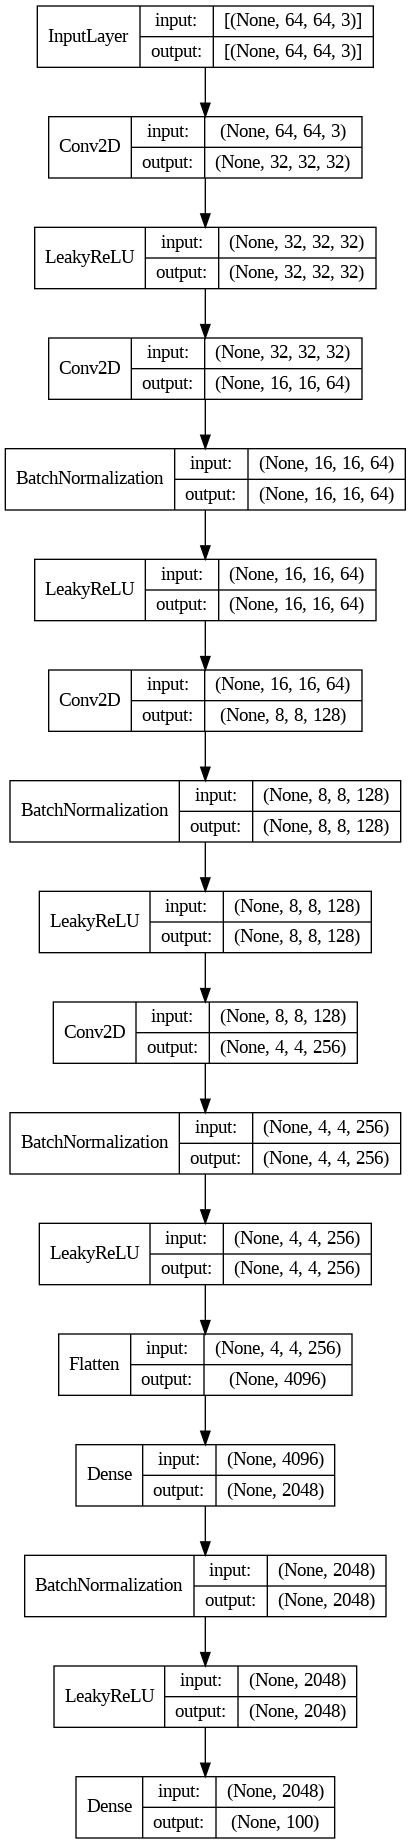

In [ ]:
plot_model(encoder, show_shapes = True, show_layer_names=False)

In [ ]:
print(encoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        32832     
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                             

In [ ]:
# test encoder
x = encoder.predict(images_train[:1])
x

1/1 [==============================] - 8s 8s/step


array([[-13.808196  ,   9.342619  ,  -5.5797834 ,  15.382946  ,
         -7.9792933 , -21.634146  ,  -0.89759636,  10.613674  ,
          9.87917   , -11.794913  ,   1.1287318 ,   9.072046  ,
         -1.2282376 ,   0.5498158 ,   0.9941778 ,  -7.067726  ,
         -8.691421  ,  -2.5493436 , -20.629536  ,  -7.502375  ,
          9.8445015 ,   7.000774  ,  -7.6050496 ,  -4.703414  ,
        -18.203268  ,  10.994957  ,  -5.869854  , -12.310668  ,
        -10.672694  , -19.81554   ,  -7.021945  ,  -9.939788  ,
        -11.463681  ,  -3.9188514 ,   6.551151  , -15.108789  ,
         -2.3503633 , -14.898394  ,   0.660306  ,  -0.18731487,
        -11.940393  ,   8.332502  ,  21.713608  ,   0.6475129 ,
         -7.2307024 , -17.773342  ,   2.146529  ,   1.6686232 ,
        -11.801428  ,  -1.9796456 ,  -4.28837   ,   8.206746  ,
          6.7946777 ,  21.306664  ,  18.174606  ,  11.1519375 ,
        -12.838085  , -10.942249  ,  -2.5773    ,  11.223061  ,
          3.098671  ,   7.9517508 ,   1.

# Train Encoder

In [ ]:
# load generator
generator = load_model('path/models/64/inmates_conditional_generator_V2_continous_epoch_final.h5')

In [ ]:
# assign data to new variables
loaded_images = images_train
y = bmi_train

In [ ]:
# Define the loss function
mse_loss = tf.keras.losses.MeanSquaredError()

# Define the optimizer
optimizer = tf.keras.optimizers.Adam()

In [ ]:
# Initialize TensorBoard
log_dir = "logs/fit/"
writer = tf.summary.create_file_writer(log_dir)


# Define training parameters
num_epochs = 300
batch_size = 128


# Define list for losses
mean_loss = []
mean_ssim = []

# Define images that are used to evaluate the model every 10 epochs
val_imgages = images_test[:10]
val_labels = bmi_test[:10]

In [ ]:
# Define the training loop
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        # Pass the input images through the encoder
        encoded = encoder(inputs, training=True)
        
        # Generate images using the pre-trained generator
        generated = generator([encoded, labels], training=False)

        # Rescale pixels to [0,255]
        generated = (generated + 1) / 2.0
        generated = generated * 255

        # Change format of input values
        inputs = tf.cast(inputs, tf.float32)
      
        # Compute the loss between the original images and the generated images
        loss = mse_loss(inputs, generated)

        ssim_v = tf.reduce_mean(tf.image.ssim(inputs, generated, 255.00))
    
    # Compute the gradients of the loss with respect to the encoder's trainable variables
    gradients = tape.gradient(loss, encoder.trainable_variables)
    
    # Update the encoder's trainable variables using the optimizer
    optimizer.apply_gradients(zip(gradients, encoder.trainable_variables))
    
    # Return the loss & ssim value
    return loss, ssim_v

In [ ]:
# Train the encoder
for epoch in range(num_epochs):
    number_of_batches = int(len(loaded_images) / batch_size)

    epoch_loss = []
    epoch_ssim = []

    # Initialize the progress bar
    progress_bar = tqdm(range(number_of_batches), desc=f"Epoch {epoch+1}/{num_epochs}")

    for index in progress_bar:
        # Load one batch of images and scales pixels to [-1,1]
        images_batch = loaded_images[index * batch_size:(index + 1) * batch_size]

        # Load corresponding label
        y_batch = y[index * batch_size:(index + 1) * batch_size]

        # Apply training loop for one batch
        loss, ssim_v = train_step(inputs = images_batch, labels = y_batch)

        # Append values to loss and SSIM to list
        epoch_loss.append(loss)
        epoch_ssim.append(ssim_v)

        # Log losses to TensorBoard
        with writer.as_default():
            tf.summary.scalar('Encoder Loss', loss, step=epoch)
            tf.summary.scalar('SSIM', ssim_v, step=epoch)
            writer.flush()

        # Update the progress bar with the latest loss and ssim values
        progress_bar.set_postfix(loss=loss.numpy(), ssim=ssim_v.numpy())

    mean_loss.append(np.mean(epoch_loss))
    mean_ssim.append(np.mean(epoch_ssim))


    if (epoch + 1) % 10 == 0:


        val_encoded = encoder.predict(val_imgages, verbose = 0)
        val_generated = generator.predict([val_encoded, val_labels], verbose = 0)

        generated_images = (val_generated + 1) / 2.0 * 255

        generated_images = generated_images.astype(np.uint8)
        val_imgages = val_imgages.astype(np.uint8)
        
        similartiy_index = tf.image.ssim(val_imgages, generated_images, 255.00)
        similartiy_index = np.round(similartiy_index, 4)


        # Prepare the plot for validation images
        sample_grid = create_image_grid(val_imgages, generated_images,  val_labels, similartiy_index)
        # save the figure
        sample_grid.savefig('path/image_grids/image_grid_epoch_' + str(epoch+1) + '.png')
        # Convert to image and log
        with writer.as_default():
          tf.summary.image("Validation Grid", plot_to_image(sample_grid), step=epoch)

        # save the model with a different name for each epoch and include date and time
        now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        model_name = 'path/inmates_encoder_continous_epoch_' + str(epoch+1) + '_' + now + '.h5'
        encoder.save(model_name)

In [ ]:
encoder.save("path/encoder_final.h5")

In [ ]:
# Define file name
csv_file = 'mean_loss_and_ssim.csv'

# Define headers
headers = ['Epoch', 'MSE', 'SSIM']

# Create a list to hold all the mean loss and accuracy values for each epoch
all_means = [mean_loss, mean_ssim]

# Open the file for writing
with open(csv_file, 'w') as file:
    # Create a CSV writer
    writer = csv.writer(file)
    
    # Write headers
    writer.writerow(headers)
    
    # Loop through each epoch
    for i in range(len(mean_loss)):
        # Create a list to hold the values for this epoch
        row = [i+1]
        # Loop through each mean value and append to the row
        for values in all_means:
            row.append(values[i])
        # Write the row to the CSV
        writer.writerow(row)


# Combine Encoder and cGAN

In [ ]:
encoder = load_model("path/encoder_final.h5", custom_objects={'euclidean_distance_loss':euclidean_distance_loss})

In [ ]:
latent_vector = encoder.predict(images_test[:1])
latent_vector

1/1 [==============================] - 0s 42ms/step


array([[ 0.18473259,  1.2770495 ,  0.5088156 , -0.5178903 , -0.3745549 ,
        -0.7964187 , -0.6323986 , -0.7597411 , -0.5996014 , -0.84810865,
         0.6703265 ,  0.1565237 , -0.5788871 , -0.52837384,  0.39666724,
         1.1662463 ,  0.76409423,  0.2655446 ,  1.7318947 , -0.18284068,
        -1.1417513 , -0.9460739 ,  0.27945948, -0.7538172 , -0.12131792,
         0.2930202 , -0.07184529,  0.123014  , -0.01990607,  1.5334165 ,
        -1.4315048 , -0.37341943,  0.21547286, -0.42929083, -0.03311354,
         1.3871908 ,  1.0637842 ,  0.31236553, -0.61026496,  0.11145562,
        -0.28521502,  1.400083  ,  0.216631  ,  0.23482214,  0.23534422,
         0.55537647,  0.28421718, -0.9182764 , -0.14892076,  1.0899217 ,
         1.4844724 , -0.31115076,  1.009316  , -0.7280695 ,  0.1957529 ,
         0.23570415,  0.49018314, -0.2533679 , -0.41797835, -0.42058998,
        -0.34352937, -0.19049086, -1.2684981 , -1.3791807 , -0.0051925 ,
        -0.39905852, -1.6216757 , -1.4770635 , -0.5

1/1 [==============================] - 0s 22ms/step


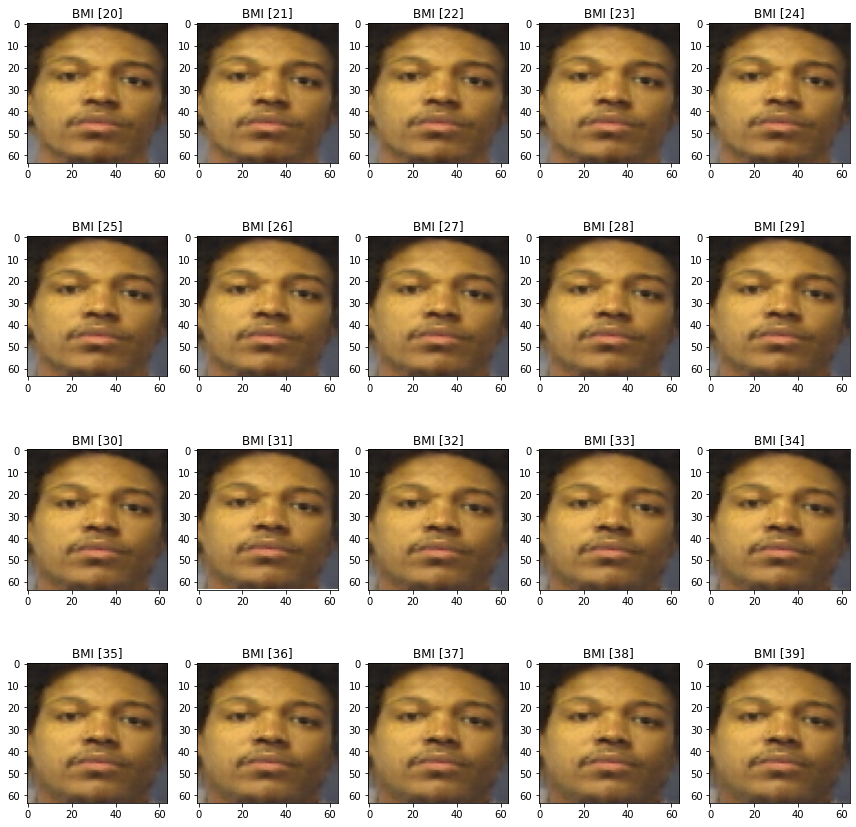

In [ ]:
# create a 4x5 grid of subplots
fig, axs = plt.subplots(4, 5, figsize=(12,12))

# iterate through each label and plot the corresponding image
for label, ax in zip(range(20, 40), axs.flatten()):
    label = np.array([label])
    X = generator.predict([latent_vector, label])
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    X = (X * 255).astype(np.uint8)
    ax.imshow(X[0])
    ax.set_title(f"BMI {label}")

plt.tight_layout()
plt.show()